In [1]:
%cd ..
!pwd

/Users/andrew/PycharmProjects/OpenILT
/Users/andrew/PycharmProjects/OpenILT


In [2]:
import torch
import matplotlib.pyplot as plt
import opc.iccad13 as iccad
from utils.layout import getCrops, getShapes, readLayout
from utils.polygon import dissect, segs2poly, poly2imgShifted, poly2img

# Simulate method

Read layout of geometry ((0, 0))-((9560, 7885))
beginX:0
beginY:0
endX:9560
endY:7885
Getting cells from a layout...
Cell 0: TOP
Bounding box: (0,0;9560,7885), selected layer: 0
X position: 0 -> 2000 / 9560, Y range: 0 - 7885, count=0
Cropped_0-0_2000-2000
Cropped_0-1000_2000-3000
In total 2 crops


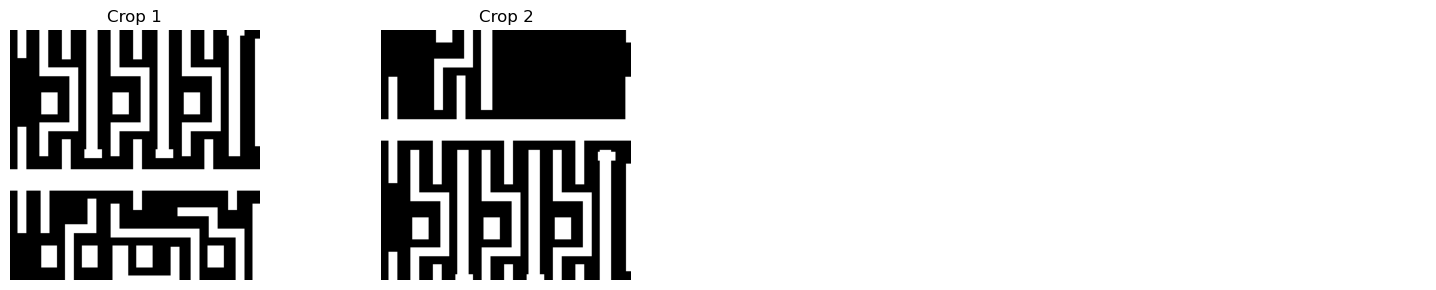

In [4]:
CROP_NUM = 2

def plot_images(num_images, images, titles=None):
    # Calculate the number of rows needed
    num_rows = (num_images + 3) // 4  # Ceiling division to ensure enough rows
    
    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each image
    for i in range(num_images):
        axes[i].imshow(poly2imgShifted(images[i], sizeX=2000, sizeY=2000), cmap='gray' if len(poly2imgShifted(images[i], sizeX=2000, sizeY=2000).shape) == 2 else None)
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')  # Hide axes
    
    # Hide any remaining empty subplots
    for j in range(num_images, num_rows * 4):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

infile = readLayout(filename = 'tmp/test1.gds', layer = 0)
crops, coords = getCrops(infile, layer = 0, sizeX = 2000, sizeY = 2000, 
                         strideX = 1000, strideY = 1000, maxnum = CROP_NUM, 
                         verbose = True)

print(f"In total {len(crops)} crops")
titles = [f"Crop {i+1}" for i in range(len(crops))]

plot_images(num_images = CROP_NUM, images = crops, titles = titles)

Мы нарезали топологию на патчи и отобразили только лишь первые 10 патчей

Нарезка шла от левого нижнего угла, снизу вверх со смещением `strideX`, затем сдвигаемся по горизонтали cо смещением `strideY`.

Размер окна: `sizeX` , `sizeY`

Метод `getCrops` выдаёт нам список bottom-left (x,y) координат у патчей. `coords: [(x1,y1), (x2,y2), ,  ,(xn, yn)]`, где **n** число патчей.

Переменная `crops` представляет собой список из патчей.  `crops:[crops[0], crops[1], ..., crops[n-1]]`.

В свою очередь каждый патч представялет собой полигонов. `crops[i]: [polygon[0], polygon[1], ..., polygon[m]]`

Полигон - список кортежей (x,y) координат. `polygon: [(x1, y1), (x2, y2), , (xk, yk)]`

In [4]:
print(f'Coords: {coords}')
print(f'Length: {len(coords)}\n')

PATCH_IDX = 1
print(f'Отобразим {PATCH_IDX + 1} патч : {crops[PATCH_IDX]}\n') # для примрера отобразили 2- ой патч
print(f'Число полигонов в рассматриваемом патче: {len(crops[PATCH_IDX])}')
print(f'Общее число патчей: {len(crops)}') 

Coords: [(0, 0), (0, 2000)]
Length: 2

Отобразим 2 патч : [[(60, 0), (60, 115), (0, 115), (0, 285), (60, 285), (60, 625), (130, 625), (130, 285), (605, 285), (605, 635), (675, 635), (675, 285), (1955, 285), (1955, 625), (2000, 625), (2000, 115), (1625, 115), (1625, 0), (1555, 0), (1555, 115), (1055, 115), (1055, 0), (985, 0), (985, 115), (485, 115), (485, 0), (415, 0), (415, 115), (130, 115), (130, 0)], [(60, 1175), (60, 1515), (0, 1515), (0, 1685), (60, 1685), (60, 2000), (130, 2000), (130, 1685), (2000, 1685), (2000, 1175), (1955, 1175), (1955, 1515), (675, 1515), (675, 1275), (605, 1275), (605, 1515), (130, 1515), (130, 1175)], [(1960, 1870), (1960, 2000), (2000, 2000), (2000, 1870)], [(235, 0), (235, 40), (305, 40), (305, 0)], [(610, 0), (610, 40), (700, 40), (700, 0)], [(805, 0), (805, 40), (875, 40), (875, 0)], [(1180, 0), (1180, 40), (1270, 40), (1270, 0)], [(1375, 0), (1375, 40), (1445, 40), (1445, 0)], [(1735, 0), (1735, 25), (1750, 25), (1750, 40), (1840, 40), (1840, 25), (18

Получим `top-left` (правый верхний угол) координаты для региона из нескольких патчей с учётом задаваемого масштаба: 

In [6]:
bigsim = iccad.PatchSim(iccad.LithoSim(), sizeX=2000, sizeY=2000, scale=0.125)

ymax, xmax = bigsim.getSize(coords)

print(f'ymax, xmax: {ymax, xmax}')

ymax, xmax: (500, 250)


На примере разбираем как работает внутренний цикл в методы `concatenate` класса **PatchSim**.

При этом учитываются два сценария использования/пользовательского ввода: 
1. `CROPS` > `BATCH_SIZE`
2. `CROPS` < `BATCH_SIZE`

В модуле `opc.iccaad13` рассмотрен случай, когда число патчей равно 2, а размер батча равен 16

In [7]:
CROPS = 2
BATCH_SIZE = 5


for idx in range(0, CROPS, BATCH_SIZE):
    print(f'idx: {idx}')
    for jdx in range(idx, min(CROPS, idx + BATCH_SIZE)):
        print(f'idx-jdx: {idx}-{jdx}')
    for jdx in range(idx, min(CROPS, idx + BATCH_SIZE)):
        index = jdx - idx
        print(f'Inner index: {index}')

idx: 0
idx-jdx: 0-0
idx-jdx: 0-1
Inner index: 0
Inner index: 1


In [8]:
# преобразуем патчи в виде набора координат полигонов в изображения, соберём их в список
image_list = [(poly2img(crops[idx], sizeX=2000, sizeY=2000, scale=0.125 ) / 255) for idx in range(len(crops))]
# преобразуем к формату тензоров
tensor_list = list(map(lambda x: torch.tensor(x, dtype=torch.float32), image_list))
print(f'tensor image list: {tensor_list}\n')
# объединим их вдоль вертикальной оси
stacked_image = torch.stack(tensor_list, dim=0)
print(f'stacked image tensors: {stacked_image}\n')
print(f'stacked tensor shape: {stacked_image.shape}')

tensor image list: [tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])]

stacked image tensors: tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
      

In [9]:
pNom, _, _ = bigsim._simulator(stacked_image)
print(f'pNom shape: {pNom.shape}')

pNom shape: torch.Size([2, 250, 250])


In [13]:
savedMask = [stacked_image[0], stacked_image[1]]
savedNom = [pNom[0], pNom[1]]

# Concat method

In [25]:
raw_mask = torch.zeros((10, 10))
exclude_left_right = raw_mask.clone()
exclude_top_bottom = raw_mask.clone()
exclude_all = raw_mask.clone()

exclude_left_right[:, 2:-2] = 1
print(f'Excluded left and right boundaries:')
print(exclude_left_right, '\n') 

exclude_top_bottom[2:-2, :] = 1
print(f'Excluded bottom and top boundaries:')
print(exclude_top_bottom, '\n')

exclude_all[2:-2, 2:-2] = 1
print(f'Excluded bottom and top boundaries:')
print(exclude_all)

Excluded left and right boundaries:
tensor([[0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.]]) 

Excluded bottom and top boundaries:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 

In [22]:
raw_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])